# Pre-processing 

This notebook is organized into three (3) parts.

Part 1: Importing seismic attribute profile and calculating cross-correlation between attribute and porosity data at well site.

Part 2: Random sampling of attribute values for individual stratigraphic units in the model down-dip direction (i.e. oriented landward - oceanward)

Part 3: Random sampling of attribute values for individual stratigraphic units in the model strike direction (i.e. oriented along shore)

# PART 1 - Seismic attribute - well log correlation

In [1]:
#module imports and function definitions
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import numpy as np
import random
from PIL import Image
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import scipy.spatial.distance as dist
import scipy
from scipy.optimize import curve_fit
from sklearn import preprocessing

#Functions
def norml(data):
    mx = max(data)
    mn = min(data)
    base = mx-mn
    normdata = np.zeros(len(data))
    for i in range(len(data)):
        normdata[i] = (data[i]-mn)/base
    return normdata

def exponential_trend(x, a, b):
    return a*np.exp(b*x)

def lin_trend(x, a, b):
    return a+b*x

## Importing seismic attribute profile and converting from RGB - Grayscale

In [2]:
filename = 'Data/RelAcImp_OC270_529'  #png image of relative acoustic impedance attribte generated in Petrel from 2D depth migrated seismic line Oc270.529
y_mod =81600  #true length of seismic line in meters
z_mod = 1700  #true depth of seismic line in meters
seis = img.imread('%s.png' % filename)
dims = seis.shape  # reading size of file in pixels
y_pix = np.linspace(0, y_mod, dims[1])  # creating x- and y- pixels vector for plotting
z_pix = np.linspace(0, z_mod, dims[0])

#Column position of well trajectory on image
m27y = 241 
m28y = 458 
m29y = 605

# Converting RGB to Int value
seis_int = np.zeros((dims[0], dims[1]))
for j in range(0, dims[1]):
    for k in range(0, dims[0]):
        seis_int[k, j] = 0.299*seis[k, j, 0]+0.587*seis[k, j, 1] + \
            0.114*seis[k, j, 2]  # grayscale conversion using weighted or luminosity method
        #(https://www.dynamsoft.com/blog/insights/image-processing/image-processing-101-color-space-conversion/)

## QC Visualisation

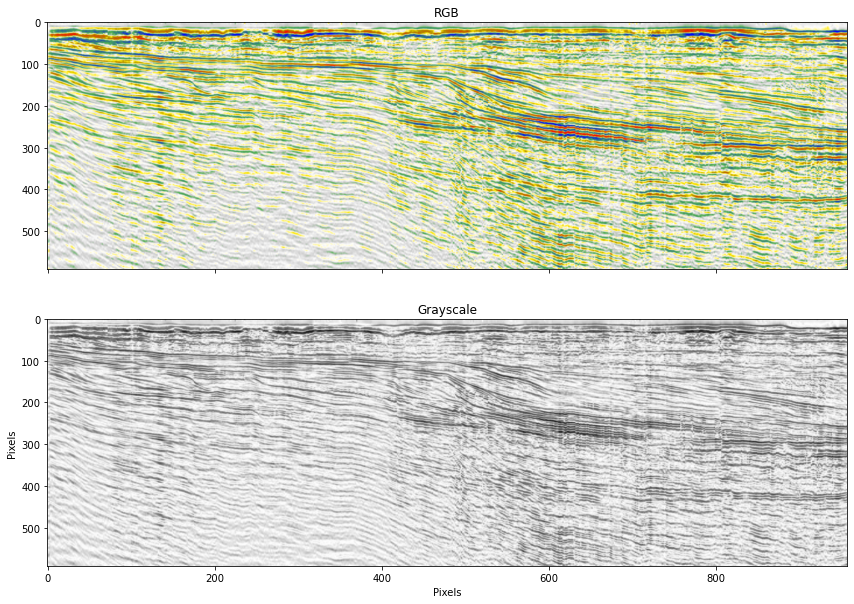

(592, 958, 3)


In [8]:
seis = img.imread('%s.png' % filename)
fig1, (ax1, ax3) = plt.subplots(2,figsize=(20,10), sharex=True)
ax1.imshow(seis)
ax1.set_title('RGB')

ax3.imshow(seis_int, cmap='gray', vmin=0, vmax=1)
ax3.set_title('Grayscale')
plt.xlabel('Pixels')
plt.ylabel('Pixels')

ax1.set_aspect(aspect=0.5)
# ax2.set_aspect(aspect=0.5)
ax3.set_aspect(aspect=0.5)

fig1 = plt.gcf()
plt.show()
print(seis.shape)


## Extracting pseudo-log of attribute amplitude

In this cell, the top and base of the well locations are calculate in terms of pixels and a Z vector for the well trajectory in terms of pixels is written to a dataframe for further steps.

In [12]:
# adjust datum to oceanfloor (bsf--> below sea floor) M27
tp27 = (np.abs(z_pix[:] - 31)).argmin()  
# user input: index corresponding to base md of well
base27 = idx = (np.abs(z_pix[:] - 562)).argmin()
z_bsf27 = z_pix[tp27:base27]-31 

# adjust datum to oceanfloor (bsf--> below sea floor) M28
tp28 = (np.abs(z_pix[:] - 258)).argmin()  # adjusted for missing upper section of well data
# user input: index corresponding to base md of well
base28 = idx = (np.abs(z_pix[:] - 703)).argmin()
z_bsf28 = z_pix[tp28:base28]-35 

# adjust datum to oceanfloor (bsf--> below sea floor)
tp29 = (np.abs(z_pix[:] - 37)).argmin()  # user input: index of top of well
# user input: index corresponding to base md of well
base29 = idx = (np.abs(z_pix[:] - 792)).argmin()
z_bsf29 = z_pix[tp29:base29]-37 

#Write Z vector to dataframe
my_dict = dict( M27 = z_bsf27, M28 = z_bsf28, M29 = z_bsf29 )
df = pd.DataFrame.from_dict(my_dict, orient='index')
pix_z = df.transpose()
pix_z

,M27,M28,M29
0,0.641286,223.883249,0.394247
1,3.517766,226.759729,3.270728
2,6.394247,229.636210,6.147208
3,9.270728,232.512690,9.023689
4,12.147208,235.389171,11.900169
...,...,...,...
257,NaN,NaN,739.649746
258,NaN,NaN,742.526227
259,NaN,NaN,745.402707
260,NaN,NaN,748.279188


## Loading well data

In [14]:
# import data
# single wells
por_data_m27 = pd.read_csv("Data/Wells/m27_por_method2.csv")
por_data_m28 = pd.read_csv("Data/Wells/m28_por_method2.csv")
por_data_m29 = pd.read_csv("Data/Wells/m29_por_method2.csv")
df27 = pd.read_csv('Data/Wells/M27_physprop.csv')
df28 = pd.read_csv('Data/Wells/M28_physprop.csv')
df29 = pd.read_csv('Data/Wells/M29_physprop.csv')


#extract log of pixel values
avg = 10  # averaging window length
pix_val_27_avg = np.mean(seis_int[:, m27y-avg:m27y+avg], 1)
pix_val_28_avg = np.mean(seis_int[:, m28y-avg:m28y+avg], 1)
pix_val_29_avg = np.mean(seis_int[:, m29y-avg:m29y+avg], 1)
# interp Seismic attribute values at log data points
pix_resamp27 = np.interp(-por_data_m27['Z'], pix_z['M27'].dropna(), pix_val_27_avg[tp27:base27])
pix_resamp28 = np.interp(-por_data_m28['Z'], pix_z['M28'].dropna(), pix_val_28_avg[tp28:base28])
pix_resamp29 = np.interp(-por_data_m29['Z'], pix_z['M29'].dropna(), pix_val_29_avg[tp29:base29])
#adding attribute values to df
por_data_m27.insert(4,'Attr',pix_resamp27,True)
por_data_m28.insert(4,'Attr',pix_resamp28,True)
por_data_m29.insert(4,'Attr',pix_resamp29,True)
#importing Physical property logs
# data source :  https://iodp.pangaea.de/front_content.php?idcat=313
# M27
phys_data27 = df27.rename(columns={'Depth [m]': 'Z'})
AI=phys_data27['Vp [m/s]']*phys_data27['WBD [g/cm**3]'].mul(1000)
phys_data27.insert(6,'AI',AI,True)
# M28
phys_data28 = df28.rename(columns={'Depth [m]': 'Z'})
AI=phys_data28['Vp [m/s]']*phys_data28['WBD [g/cm**3]'].mul(1000)
phys_data28.insert(6,'AI',AI,True)
# M29
phys_data29 = df29.rename(columns={'Depth [m]': 'Z'})
AI=phys_data29['Vp [m/s]']*phys_data29['WBD [g/cm**3]'].mul(1000)
phys_data29.insert(6,'AI',AI,True)
# interp AI values at porosity data points
ai_resamp27 = np.interp(-por_data_m27['Z'], phys_data27['Z'], phys_data27['AI'])
ai_resamp28 = np.interp(-por_data_m28['Z'], phys_data28['Z'], phys_data28['AI'])
ai_resamp29 = np.interp(-por_data_m29['Z'], phys_data29['Z'], phys_data29['AI'])
#adding AI values to df
por_data_m27.insert(5,'AI',ai_resamp27,True)
por_data_m28.insert(5,'AI',ai_resamp28,True)
por_data_m29.insert(5,'AI',ai_resamp29,True)



# combine in single df, sort for n-score transform later
df = pd.concat([por_data_m27, por_data_m28, por_data_m29],ignore_index=True)
#df = df.sort_values(by=['Porosity'])

# Add well information fo later 
def derive_well(row):
    if row['X'] == por_data_m27.values[0,0]:
        return 'm27'
    elif row['X'] == por_data_m28.values[0,0]:
              return 'm28'
    elif row['X'] == por_data_m29.values[0,0] :
              return 'm29'
    return 'Other'

df["Well"] = df.apply(lambda row: derive_well(row), axis=1)
df.to_csv('Data/Well_log_data.csv',index=False)
df

,X,Y,Z,Porosity,Attr,AI,Sequence,Well
0,41600,74700,-0.35,36.3,0.945882,3523177.0,m1,m27
1,41600,74700,-1.85,32.2,0.944976,NaN,m1,m27
2,41600,74700,-2.77,24.7,0.944286,NaN,m1,m27
3,41600,74700,-4.27,32.9,0.935778,NaN,m1,m27
4,41600,74700,-5.81,37.3,0.919506,3576454.0,m1,m27
...,...,...,...,...,...,...,...,...
936,40100,46300,-747.21,43.8,0.631952,NaN,m58,m29
937,40100,46300,-748.80,41.5,0.651549,NaN,m58,m29
938,40100,46300,-753.10,46.2,0.654028,2881350.0,m58,m29
939,40100,46300,-754.62,44.5,0.654028,2964948.0,m58,m29


## Calculating Spearmann's Correlation Coefficient

In [15]:
# calculating Corr. Coeff.
sr=12
corrAI, rank1 = spearmanr(norml(df['Porosity'][df['Well']=='m27'].values[2::sr]),norml(df['Attr'][df['Well']=='m27'].values[2::sr]))


corrAI_28, rank2 = spearmanr(norml(df['Porosity'][df['Well']=='m28'].values[0::sr]),norml(df['Attr'][df['Well']=='m28'].values[0::sr]))


corrAI_29, rank3 = spearmanr(norml(df['Porosity'][df['Well']=='m29'].values[3::sr]),norml(df['Attr'][df['Well']=='m29'].values[3::sr]))




## Visualisation

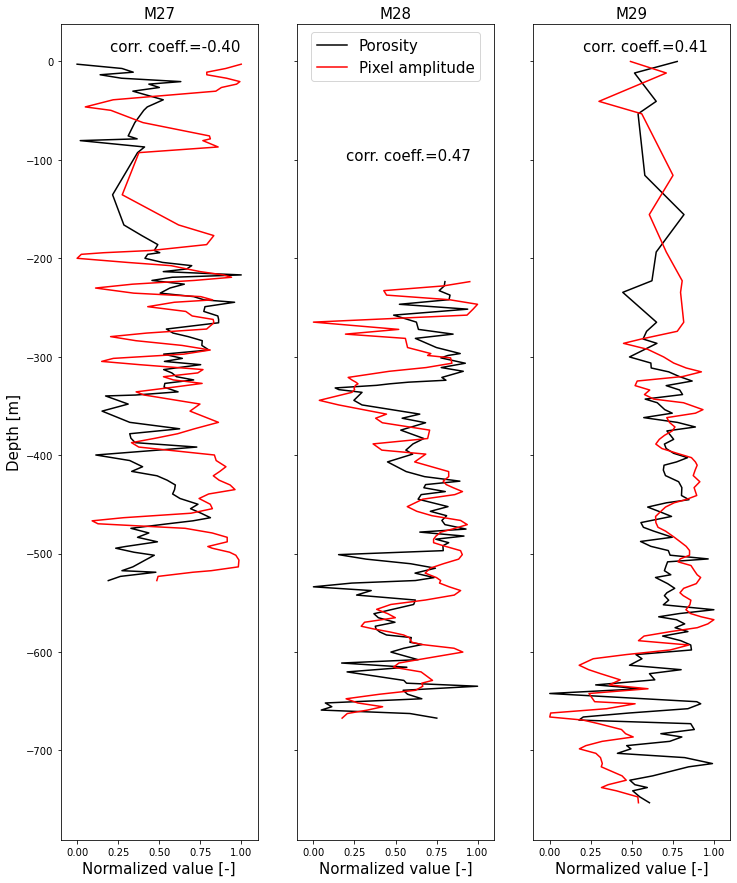

In [20]:
#  Cross Plot Porosity vs AI
sr=3
m27z=df['Z'][df['Well']=='m27'].values[2::sr]
m28z=df['Z'][df['Well']=='m28'].values[0::sr]
m29z=df['Z'][df['Well']=='m29'].values[0::sr]

fig2, axs2 = plt.subplots(1, 3, figsize=(12, 15),sharey=True)

# M27-----------------------------------------------
axs2[0].plot(norml(df['Porosity'][df['Well']=='m27'].values[2::sr]),m27z,color='black',label='Porosity')
axs2[0].plot(norml(df['Attr'][df['Well']=='m27'].values[2::sr]),m27z,color='red',label='Pixel amplitude')
axs2[0].set_title('M27',fontsize='15')
axs2[0].set_xlabel('Normalized value [-]',fontsize='15')
axs2[0].set_ylabel('Depth [m]',fontsize='15')
axs2[0].text(0.20, 10, 'corr. coeff.={:.2f}'.format(corrAI),fontsize='15')
#axs2[0].legend()
# M28-----------------------------------------------
axs2[1].plot(norml(df['Porosity'][df['Well']=='m28'].values[0::sr]),m28z,color='black',label='Porosity')
axs2[1].plot(norml(df['Attr'][df['Well']=='m28'].values[0::sr]),m28z,color='red',label='Pixel amplitude')
axs2[1].set_title('M28',fontsize='15')
axs2[1].set_xlabel('Normalized value [-]',fontsize='15')
axs2[1].text(0.20,-100, 'corr. coeff.={:.2f}'.format(corrAI_28),fontsize='15')
#axs2[1].set_ylim(-700,30)
axs2[1].legend(loc='upper center',fontsize='15')
# M29-----------------------------------------------
axs2[2].plot(norml(df['Porosity'][df['Well']=='m29'].values[2::sr]),m29z,color='black',label='Porosity')
axs2[2].plot(norml(df['Attr'][df['Well']=='m29'].values[2::sr]),m29z,color='red',label='Pixel amplitude')
axs2[2].set_title('M29',fontsize='15')
axs2[2].set_xlabel('Normalized value [-]',fontsize='15')
axs2[2].text(0.2,10, 'corr. coeff.={:.2f}'.format(corrAI_29),fontsize='15')
#fig2.suptitle('Cross-correlation Seismic Attr. vs Porosity', fontsize=16)
for ax in axs2:
    #ax.set_ylim(-800,0)
    ax.set_xlim(-0.1,1.1)

plt.show()

fig2.savefig('Figures/Well_log_attr_por.jpg',dpi=450,bbox_inches='tight')

# PART 2: Random sampling of stratigraphic units - dip orientation

The input data for this section of the analysis is the attribute profile, divided into the individual stratigraphic units according to the interpretation. This is done by setting the seismic amplitude to zero outside of the bounds of the top and basal surface of the unit.

NB: User input required

This analysis has to iterated over each unit and thus requires the user to change the name of the stratigraphic unit and run all the cells in this part.
The unit names are composed of the basal sequence boundary name and the orientation seperated by an underscore. They are listed here:  
m1  
m41  
m5  
m54  
m58  
m6  
o1  

The name must be entered in the first line of the following cell into as the 'unit', to generate the dataset for the corresponding unit.

In [2]:
def def_range(unit):
    '''Presets the depth range depending on the stratigraphic unit for plotting to same scale
    in both strike and dip lines'''
    if unit=='m1':
        y2=-300
        y1=0
    elif unit=='m41':
        y2=-650
        y1=-50
    elif unit=='m5':
        y2=-800
        y1=-150
    elif unit=='m54':
        y2=-900
        y1=-100
    elif unit=='m58':
        y2=-1000
        y1=-150
    elif unit=='m6':
        y2=-900
        y1=-250
    elif unit=='o1':
        y2=-1250
        y1=-300
    return(y2,y1)
    
    

## Read and trim image

Note: All images were exported from Petrel with the same scale, this scale is used to convert from pixels to SI units for distances. Visual inspection was used to trim the white edges of the image files, this is hard coded into the script.

In [3]:
unit='o1' # <<<<<Stratigraphic unit defined HERE
(y2,y1)=def_range(unit)
suffix='dip'
filename=('{}_{}'.format(unit,suffix))
y_mod=134000
z_mod=1700
seis=img.imread('Data\AttributeSections\%s.png' % filename)

seis_clean=seis[63:652,228:1184,:] #Trimming the white edges of the image files.

dims=seis_clean.shape

## RGB to Grayscale

In [4]:
seis_int=seis_clean[:,:,0]
for j in range(0,dims[1]):
    for k in range(0,dims[0]):
        seis_int[k,j]=0.299*seis_clean[k,j,0]+0.587*seis_clean[k,j,1]+0.114*seis_clean[k,j,2]

## QC Visualisation

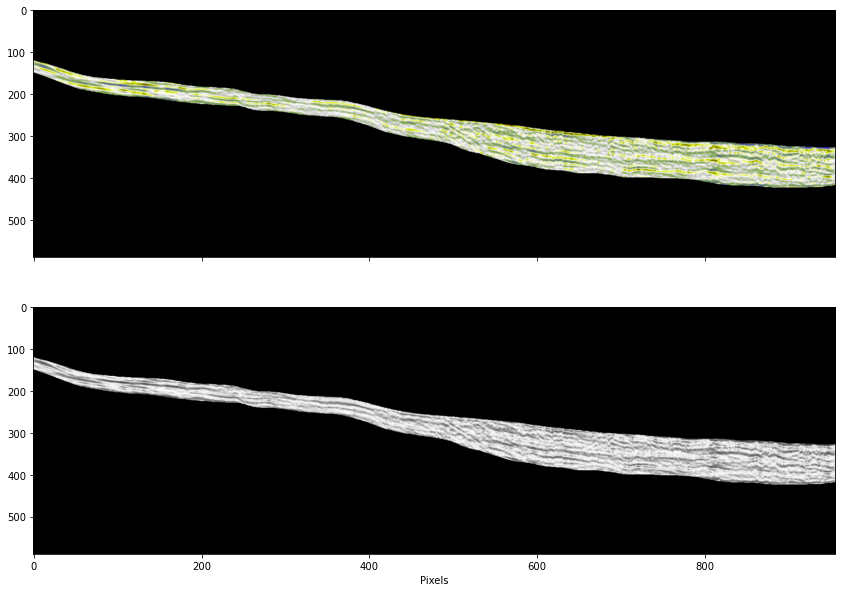

In [5]:

fig1,(ax1,ax3)=plt.subplots(2,figsize=(20,10),sharex=True)        
ax1.imshow(seis_clean)
ax3.imshow(seis_int,cmap='gray',vmin=0,vmax=1)
plt.xlabel('Pixels')
ax1.set_aspect(aspect=0.5)
ax3.set_aspect(aspect=0.5)
fig1=plt.gcf()
plt.show()

## Data preparation 

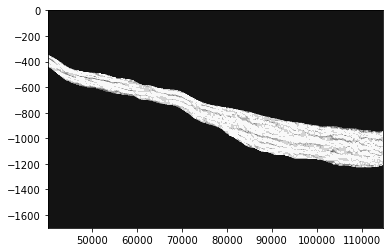

In [6]:
dims=seis_clean.shape
y_pix=np.linspace(40220,114720,dims[1])
z_pix=np.linspace(0,z_mod,dims[0])
yloc=np.zeros((dims[0],dims[1]))
zloc=np.zeros((dims[0],dims[1]))
 

for j in range(0,dims[1]):
    zloc[:,j]=0-z_pix
for k in range(0,dims[0]):  
    yloc[k,:]=y_pix
plt.contourf(yloc,zloc,seis_int,cmap='gray',vmin=0,vmax=1)
plt.show()
# # dipline
xx=40800*np.ones((dims[0]*dims[1]))
#data_out=np.stack((xx,np.flipud(yloc.flatten()),zloc.flatten(),seis_int.flatten()),axis=1)
data_out=np.stack((xx,yloc.flatten(),zloc.flatten(),seis_int.flatten()),axis=1)

#Save data
np.savetxt('Temp\%s_xyz.txt'% filename,
           data_out,delimiter=',',
           fmt='%10.3f')

## Clean-up and random selection

In [7]:
#clean up
data_in=open('Temp\%s_xyz.txt'% filename,'r').readlines()


with open('Temp\%s_xyz_clean.txt' % filename, 'w') as outfile:
    for line in data_in:
        check=line.strip().split(',')[3]
        check2=line.strip().split(',')[2]
        if check!='     0.000' and check2!='     0.000':
            outfile.write(line)
outfile.close()
# random selection
data_clean=open('Temp\%s_xyz_clean.txt'% filename,'r').readlines()
full=len(data_clean)
samp_size=int(0.25*full) # set sample size of pixels  <<<<< Percentage sample size defined HERE
data_ran_samp=random.sample(data_clean,samp_size)
with open('Data\Attr_dip\%s_xyz_clean_ran.txt' % filename, 'w') as outfile:
    outfile.write('#X,Y,Z,attr \n')
    for line in data_ran_samp:
        outfile.write(line)
outfile.close()

## Visualising the data selection

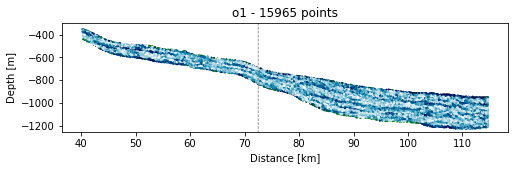

In [8]:
data = np.genfromtxt('Data\Attr_dip\%s_xyz_clean_ran.txt' % filename, delimiter=',')
num=data.shape[0]
xc=72.5*np.ones([1700,1])  #position of cross line
zc=np.linspace(0,-1700,1700)
fig2,ax=plt.subplots(figsize=(8,2))
pts=plt.scatter(data[0::,1]/1000,data[0::,2],c=data[0::,3],s=1,cmap='ocean')
plt.plot(xc,zc,'--',linewidth=0.75,color='gray') #intersection of line 22
#ax.set_xlim(0,134)
ax.set_ylim(y2,y1)
plt.title('{} - {} points'.format(unit,num))
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
#cbar=fig2.colorbar(pts,orientation="horizontal", pad=0.2)
#cbar.ax.set_xlabel('Normalized amplitude', rotation=0)
plt.show()
#fig2.savefig('Figures\Dipline_%s.jpg'%filename,dpi=450,bbox_inches='tight')


# PART 3: Random sampling of stratigraphic units - strike orientation

The same procedure as in Part 2 applies for this section. 
The unit names are composed of the basal sequence boundary name and the orientation seperated by an underscore. They are listed here:  
m1  
m41  
m5  
m54  
m58  
m6  
o1  

The name must be entered in the first line of the following cell into as the 'unit', to generate the dataset for the corresponding unit.

## Read and trim image

In [124]:
#Strat units: m1, m41, m5, m54, m58, m6, o1
unit='o1'  # <<<<< Stratigraphic unit defined HERE
(y2,y1)=def_range(unit)
suffix='str'
filename=('{}_{}'.format(unit,suffix))
#define model dimensions in m
y_mod=69000
z_mod=1700
seis=img.imread('Data\AttributeSections\%s.png' % filename)

seis_clean=seis[63:652,280:925,:] #Trimming white space on image

dims=seis_clean.shape

## RGB to Grayscale

In [125]:
seis_int=seis_clean[:,:,0]
for j in range(0,dims[1]):
    for k in range(0,dims[0]):
        seis_int[k,j]=0.299*seis_clean[k,j,0]+0.587*seis_clean[k,j,1]+0.114*seis_clean[k,j,2]                  

## QC Visualisation

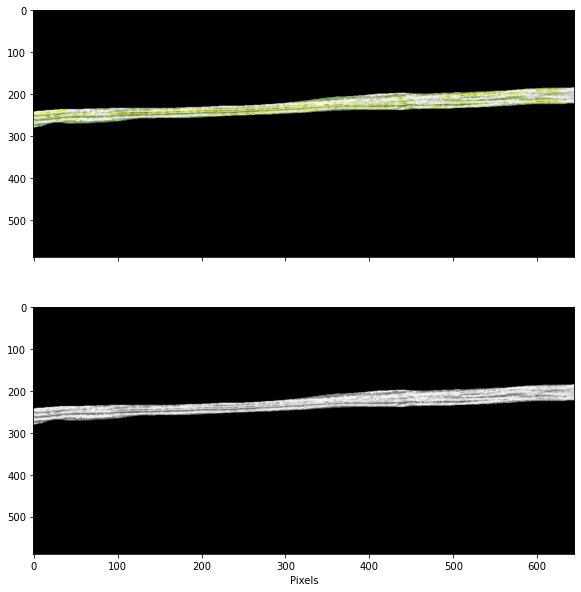

In [126]:

fig1,(ax1,ax3)=plt.subplots(2,figsize=(20,10),sharex=True)        
ax1.imshow(seis_clean)
ax3.imshow(seis_int,cmap='gray',vmin=0,vmax=1)
plt.xlabel('Pixels')
ax1.set_aspect(aspect=0.5)
ax3.set_aspect(aspect=0.5)
fig1=plt.gcf()
plt.show()

## Data preparation

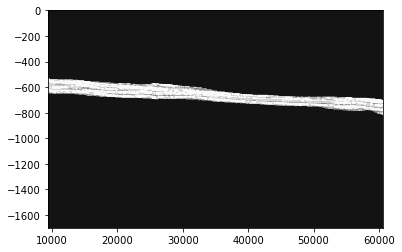

In [127]:
dims=seis_clean.shape
y_pix=np.linspace(8400,59600,dims[1])
z_pix=np.linspace(0,z_mod,dims[0])
yloc=np.zeros((dims[0],dims[1]))
zloc=np.zeros((dims[0],dims[1]))


for j in range(0,dims[1]): #trim to line 529 only
    zloc[:,j]=0-z_pix
for k in range(0,dims[0]):  
    yloc[k,:]=69000-y_pix
plt.contourf(yloc,zloc,seis_int,cmap='gray',vmin=0,vmax=1)
plt.show()
# # dipline
#xx=40800*np.ones((dims[0]*dims[1]))
# # strikeline
yy=60500*np.ones((dims[0]*dims[1]))
# # dip line
#data_out=np.stack((xx,np.flipud(yloc.flatten()),zloc.flatten(),seis_int.flatten()),axis=1)
#strike line
data_out=np.stack((yloc.flatten(),yy,zloc.flatten(),seis_int.flatten()),axis=1)

np.savetxt('Temp\%s_xyz_strike.txt'% filename,
           data_out,delimiter=',',
           fmt='%10.3f')

## Clean-up and random selection

In [128]:
data_in=open('Temp\%s_xyz_strike.txt'% filename,'r').readlines()

# clean up
with open('Temp\%s_xyz_clean_strike.txt' % filename, 'w') as outfile:
    for line in data_in:
        check=line.strip().split(',')[3]
        check2=line.strip().split(',')[2]
        if check!='     0.000' and check2!='     0.000':
            outfile.write(line)
outfile.close()
#Random sampling

data_clean=open('Temp\%s_xyz_clean_strike.txt'% filename,'r').readlines()
full=len(data_clean)
samp_size=int(0.25*full)
data_ran_samp=random.sample(data_clean,samp_size)
with open('Data\Attr_strike\%s_xyz_strike_clean_ran.txt' % filename, 'w') as outfile:
    outfile.write('#X,Y,Z,attr \n')
    for line in data_ran_samp:
        outfile.write(line)
outfile.close()

## Visualising the data selection

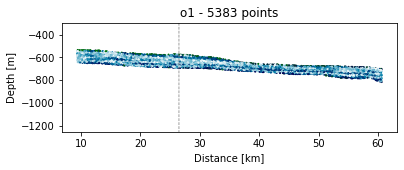

In [129]:
data = np.genfromtxt('Data\Attr_strike\%s_xyz_strike_clean_ran.txt' % filename, delimiter=',')
num=data.shape[0]
xc=26.5*np.ones([1700,1])
zc=np.linspace(0,-1700,1700)
#Plotting Figure
fig2,ax=plt.subplots(figsize=(6,2))
pts=plt.scatter(data[0::,0]/1000,data[0::,2],c=data[0::,3],s=1,cmap='ocean')
plt.plot(xc,zc,'--',linewidth=0.75,color='gray') # intersection of line 529

#ax.set_xlim(0,69)
ax.set_ylim(y2,y1)

plt.title('{} - {} points'.format(unit,num))
plt.xlabel('Distance [km]')
plt.ylabel('Depth [m]')
#cbar=fig2.colorbar(pts,orientation="horizontal", pad=0.2)
#cbar.ax.set_xlabel('Normalized amplitude', rotation=0)
plt.show()
fig2.savefig('Figures\Strikeline_%s.jpg'%filename,dpi=450,bbox_inches='tight')

